# Time Dependent Reaction Diffuison: spiral wave

This demonstrates the simulation of spiral waves in an excitable media. It consists of system of reaction diffusion equations with two components. Both the model parameters and the approach for discretizing the system are taken from http://www.scholarpedia.org/article/Barkley_model.

We use the _Barkley model_ in its simplest form:
\begin{align*}
\frac{\partial u}{\partial_t} &= \frac{1}{\varepsilon}f(u,v) + \Delta u \\
\frac{\partial v}{\partial_t} &= h(u,v)
\end{align*}
where
\begin{equation*}
f(u,v)=u\Big(1-u\Big)\Big(u-\frac{v+b}{a}\Big)
\end{equation*}
The function $h$ can take different forms, e.g., in its simplest form
\begin{equation*}
h(u,v) = u - v~.
\end{equation*}
Finally, $\varepsilon,a,b$ for more details on how to chose these parameters check the web page provided above.

We employ a carefully constructed linear time stepping scheme for this model: let $u^n,v^n$ be given functions approximating the solution at a time $t^n$. To compute approximations $u^{m+1},v^{m+1}$ at a later time
$t^{n+1}=t^n+\tau$ we first split up the non linear function $f$ as follows:
\begin{align*}
f(u,v) = f_I(u,u,v) + f_E(u,v)
\end{align*}
where using $u^*(V):=\frac{V+b}{a}$:
\begin{align*}
f_I(u,U,V) &= \begin{cases}
u\;(1-U)\;(\;U-U^*(V)\;) & U < U^*(V) \\
-u\;U\;(\;U-U^*(V)\;)    & U \geq U^*(V)
\end{cases} \\
\text{and} \\
f_E(U,V) &= \begin{cases}
0 & U < U^*(V) \\
U\;(\;U-U^*(V)\;)    & U \geq U^*(V)
\end{cases} \\
\end{align*}
Thus $f_I(u,U,V) = -m(U,V)u$ with
\begin{align*}
m(U,V) &= \begin{cases}
(U-1)\;(\;U-U^*(V)\;) & U < U^*(V) \\
U\;(\;U-U^*(V)\;)    & U \geq U^*(V)
\end{cases}
\end{align*}
Note that $u,v$ are assumed to take values only between zero and one so that therefore $m(u^n,v^n) > 0$. Therefore, the following time discrete version of the Barkley model has a linear, positive definite elliptic operator on its left hand side:
\begin{align*}
-\tau\Delta u^{n+1} +
(1+\frac{\tau}{\varepsilon} m(u^n,v^n))\; u^{n+1}
&= u^n + \frac{\tau}{\varepsilon} f_E(u^n,v^n) \\
v^{n+1} &= v^n + \tau h(u^n,v^n)
\end{align*}
Which can now be solved using a finite element discretization for $u^n,v^n$.

Note that by taking the slow reaction $h(u,v)$ explicitly, the equation for $v^{n+1}$ is purely algebraic. We will therefore construct a scalar model for computing $u^{n+1}$ only and compute $v^{{n+1}}$ be using the interpolation method on the space applied to
$v^n + \tau h(u^n,v^n)$.

Let's get started by importing some standard python packages, ufl, and some part of the dune-fempy package:

In [1]:
import ufl
import dune.ufl
import dune.grid
import dune.fem

In our attempt we will discretize the model as a 2x2 system. Here are some possible model parameters and initial conditions (we even have two sets of model parameters to choose from):

In [2]:
dimRange   = 1
dt         = 0.25
linearSpiral = True

if linearSpiral:
    spiral_a   = 0.75
    spiral_b   = 0.02
    spiral_eps = 0.02
    spiral_D   = 1./100
    def spiral_h(u,v): return u - v
else:
    spiral_a   = 0.75
    spiral_b   = 0.0006
    spiral_eps = 0.08
    def spiral_h(u,v): return u**3 - v

x = ufl.SpatialCoordinate(dune.ufl.domain(2))
initial_u = ufl.conditional(x[1]>1.25,1,0)
initial_v = ufl.conditional(x[0]<1.25,0.5,0)

Now we set up the reference domain, the Lagrange finite element space (second order), and discrete functions for $(u^n,v^n($, $(u^{n+1},v^{n+1})$:

In [3]:
gridView = dune.grid.structuredGrid([0,0],[2.5,2.5],[30,30])
space    = dune.fem.space.lagrange( gridView, dimRange=dimRange, order=1 )

uh   = space.interpolate( initial_u, name="u" )
uh_n = uh.copy()
vh   = space.interpolate( initial_v, name="v" )
vh_n = vh.copy()

We define the model in two steps:
- first we define the standard parts, not involving $f_E,f_I$:
- then we add the missing parts with the required _if_ statement directly using C++ code

In [4]:
u   = ufl.TrialFunction(space)
phi = ufl.TestFunction(space)

# right hand side (time derivative part
a_ex = ufl.inner(uh_n, phi) * ufl.dx
# left hand side (heat equation in first variable + backward Euler in time)
a_im = (dt * spiral_D * ufl.inner(ufl.grad(u), ufl.grad(phi)) +
        ufl.inner(u,phi)) * ufl.dx

ustar = (vh_n[0]+spiral_b)/spiral_a
a_ex += ufl.conditional(uh_n[0]<ustar, dt/spiral_eps* u[0]*(1-uh_n[0])*(uh_n[0]-ustar),
                                       dt/spiral_eps*uh_n[0]*(1-u[0]) *(uh_n[0]-ustar) ) * phi[0] * ufl.dx

equation   = a_im == a_ex
ode_update = ufl.as_vector([ vh_n[0] + dt*spiral_h(uh_n[0], vh_n[0]) ])

The model is now completely implemented and can be created, together with the corresponding scheme:

In [5]:
solverParameters =\
       {"nonlinear.tolerance": 1e-3,
        "nonlinear.verbose": False,
        "linear.tolerance": 1e-5,
        "linear.preconditioning.method": "jacobi",
        "linear.verbose": False}
scheme = dune.fem.scheme.galerkin( equation, space, solver="cg", parameters=solverParameters)

To show the solution we make use of the _animate_ module of _matplotlib_.
Here is the `stepping` functions:

In [6]:
def init():
    data = uh.pointData(1)
    C = plt.tricontourf(triangulation, data[:,0], cmap=plt.cm.rainbow, levels=levels)
    return C.axes.collections
def animate(count):
    global t,stepsize,nextstep
    nextstep += stepsize
    # print(count,t,stepsize,nextstep)
    while t < nextstep:
        uh_n.assign(uh)
        vh_n.assign(vh)
        info = scheme.solve(target=uh)
        vh.interpolate( ode_update )
        # print("Computing solution a t = " + str(t + dt), "iterations: " + str(info["linear_iterations"]) )
        t += dt
    data = uh.pointData(1)
    C = plt.tricontourf(triangulation, data[:,0], cmap=plt.cm.rainbow, levels=levels)
    # gridView.writeVTK("spiral", pointdata=[uh], number=count)
    return C.axes.collections

And generate the movie:

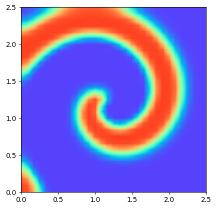

In [7]:
import matplotlib.pyplot as plt
from matplotlib import animation

from numpy import linspace
fig, ax = plt.subplots()
ax.set_xlim(( 0, 2.5))
ax.set_ylim(( 0, 2.5))
triangulation = gridView.triangulation(1)
levels = linspace(-0.1, 1.1, 256)
ax.set_aspect('equal');
t        = 0.
stepsize = 0.5
nextstep = 0.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=20, interval=100, blit=True)

try:
    movie = anim.to_html5_video()
    # save and embed
    anim.save('spiral.gif', writer=animation.ImageMagickWriter(fps=2))
    from IPython.display import HTML, display
    display( HTML(movie) )
except: # ffmpeg probably missing
    try:
        anim.save("spiral.html")
        from IPython.display import IFrame
        IFrame(src='./spiral.html', width=700, height=600)
    except:
        pass

... if the movie is not showing you might have to rerun the notebook ...